In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import accuracy_score, f1_score, precision_score , recall_score, confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve
from sklearn.metrics import roc_curve, plot_roc_curve, roc_auc_score
from sklearn.preprocessing import Binarizer

import warnings
warnings.filterwarnings(action='ignore')

sns.set()

In [2]:
def my_eval(y_val, pred, proba, th):  #avg='binary'
        accuracy = accuracy_score(y_val, pred)
        precision = precision_score(y_val, pred)
        recall = recall_score(y_val, pred)
        f1 = f1_score(y_val, pred)
        matrix = confusion_matrix(y_val, pred)
        print(f'정확도{accuracy:.4f} 정밀도:{precision:.4f} 재현률:{recall:.4f} f1:{f1:.4f}')
        print("오차행렬\n", matrix)
        # cls_report = classification_report(y_val, pred)

        # --------------- 양성 평가를 위한 차트 : precision_recall_curv() -------------------    
        # plot_precision_recall_curve(model, 문제지2, 정답지2)
        precisions, recalls, ths = precision_recall_curve(y_val, proba[:, 1])
        plt.title("precision recall curv %0.2f %0.4f"%(th,f1))
        # plt.title(f"precision recall curv %0.4f" % f1)
        plt.xlabel("threadhold")
        plt.ylabel("value")
        plt.plot(ths, precisions[:ths.shape[0]], "b", label="precision")
        plt.plot(ths, recalls[:ths.shape[0]], "r", linestyle='--', label="recall")
        plt.grid()
        plt.legend()
        plt.show()
        
        
        # --------------- 양성 평가를 위한 차트 : roc_auc_score(), roc_curve() -------------------
        auc_score = roc_auc_score(y_val, proba[:, 1])

        fprs, tprs, ths = roc_curve(y_val, proba[:, 1])
        plt.title("roc curv %0.4f" % auc_score)
        # plt.title(f"precision recall curv %0.4f" % f1)
        plt.xlabel("FPR(1-specificity)")
        plt.ylabel("TPR")
        plt.grid()
        plt.plot(fprs, tprs, "b")
        plt.plot([0, 1], [0, 1], '--', color='black')
        plt.show()


def split_fit_score(X, y, model=None, test_size=0.2, th_list=None):

        X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=test_size,random_state=1414,shuffle=False)

        model.fit(X_train, y_train)
        pred = model.predict(X_test)                                        #[0  1]              th:0.5
        proba = model.predict_proba(X_test)                                 #[[.7 >.3] [.4  <.6]]  --> [0  1]
        
        # ------------------ proba : 양성 점수 측정을 위한 예측 확률값 ---------------
        # proba 리턴값 : ndarray of shape (n_samples, n_classes)  150*3
        # [
        #     [0.4 0.6]  --> 1
        #     [0.7 0.3]  --> 0
        #     [0.42 0.58] -> 1
        # ]
        
        if th_list == None:
            #------------------방법1 ) 임계치 0.5(기본값)으로 점수 출력 ---------------
            binz = Binarizer(threshold=0.5)                              # th:0.5
            pred_binz = binz.fit_transform(proba[:, 1].reshape(-1,1))    # [[.7 >.3] [.4  <.6]]  --> [0  1]
            my_eval(y_test, pred_binz, proba, 0.5)                        # 점수def호출
 
        else:
            # ----------------방법2) 임계치 조정해가면서 최적의 점수 찾기---------------
            # (24 양성인데 틀리게예측) --> 임계치 낮춘다 == 양성학습데이터늘린다  == 양성점수를 올린다 
            th_list = [0, 0.35 , 0.38, 0.42, 0.45, 0.5, 1]
            for th in th_list:
                    binz = Binarizer(threshold=th)                              # [[.7 .3] [.4  .6]]   th:0.2
                    pred_binz = binz.fit_transform(proba[:, 1].reshape(-1,1))   # [  th<.3] [  th<.6]]  --> [1 1]
                    print(th)
                    my_eval(y_test, pred_binz, proba, th)                       #점수def호출

## 데이터 로드
<pre>
'id': 등록자 ID
'city': 지역코드
'city_development_index': 지역개발지수
'gender': 성별
'relevent_experience': 관련경험
'enrolled_university': 대학과정
'education_level': 교육수준
'major_discipline': 전공
'experience':경력(년)
'company_size': 소속회사 직원수
'company_type': 소속회사 유형
'last_new_job': 현재 직업 경력(년)
'training_hours': 교육 이수 시간
'target': 목표변수, 다른 일을 찾는 경우1, 아니면 0
</pre>

In [3]:
df = pd.read_csv("kote_train.csv")
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [4]:
df.shape  #(19158, 14)

(19158, 14)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

## EDA

1. target 확인

0.0    14381
1.0     4777
Name: target, dtype: int64


<AxesSubplot:>

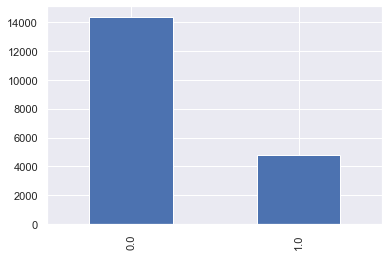

In [6]:
print(df['target'].value_counts())
df['target'].value_counts().plot(kind="bar")

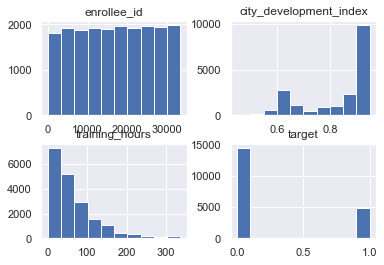

In [7]:
df.hist()
plt.show()

2.결측확인
* 결측이 있는 피쳐만 상단으로 출력
* 결측이 있는 피쳐만 출력

In [8]:
df.isna().sum().sort_values(ascending=False)

company_type              6140
company_size              5938
gender                    4508
major_discipline          2813
education_level            460
last_new_job               423
enrolled_university        386
experience                  65
enrollee_id                  0
city                         0
city_development_index       0
relevent_experience          0
training_hours               0
target                       0
dtype: int64

In [9]:
df.isna().sum()[df.isna().sum() != 0].sort_values(ascending=False) #.index


company_type           6140
company_size           5938
gender                 4508
major_discipline       2813
education_level         460
last_new_job            423
enrolled_university     386
experience               65
dtype: int64

In [10]:
nan_df = pd.DataFrame({"CNT":df.isna().sum(), "RATE":  df.isna().sum()/df.shape[0]*100   })
nan_df.sort_values('CNT', ascending=False) #.T

,CNT,RATE
company_type,6140,32.049274
company_size,5938,30.994885
gender,4508,23.530640
major_discipline,2813,14.683161
education_level,460,2.401086
last_new_job,423,2.207955
enrolled_university,386,2.014824
experience,65,0.339284
enrollee_id,0,0.000000
city,0,0.000000


3. Object 타입 피쳐 출력
* https://stackoverflow.com/questions/29245848/what-are-all-the-dtypes-that-pandas-recognizes?rq=1
* https://pandas.pydata.org/pandas-docs/stable/user_guide/basics.html#basics-dtypes

In [11]:
# df.dtypes[df.dtypes=='object'].index
obj_cols = df.dtypes[df.dtypes=='object'].index
print(obj_cols)

Index(['city', 'gender', 'relevent_experience', 'enrolled_university',
       'education_level', 'major_discipline', 'experience', 'company_size',
       'company_type', 'last_new_job'],
      dtype='object')


## 가공처리

1. 결측처리
* ['company_type', 'company_size', 'gender', 'major_discipline', 'education_level', 'last_new_job', 'enrolled_university', 'experience']

In [12]:
nan_cols = ['company_type', 'company_size', 'gender', 'major_discipline', 'education_level', 'last_new_job', 'enrolled_university', 'experience']

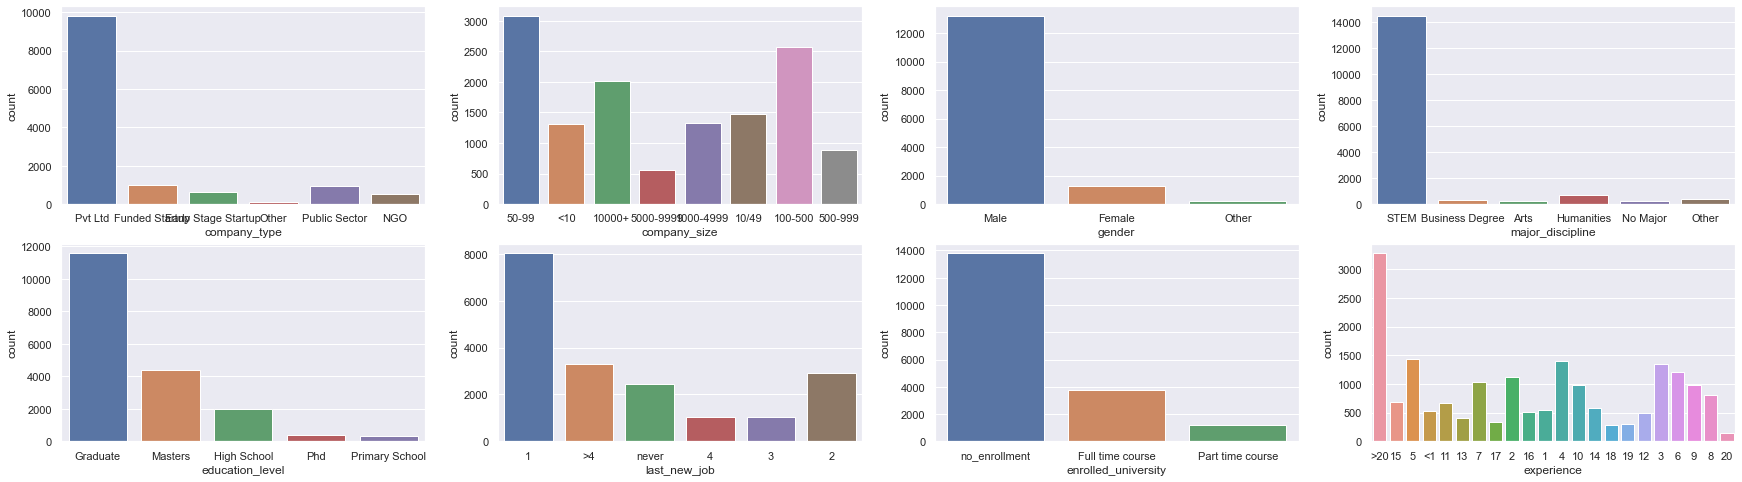

In [13]:
f,ax=plt.subplots(2,4,figsize=(30,8))
for i, col in enumerate(nan_cols) :
    c = i%4
    r = i//4
    sns.countplot(col,data=df, ax=ax[r,c])

In [14]:
for col in nan_cols:
    print(df[col].value_counts())
    print("--"*20)

Pvt Ltd                9817
Funded Startup         1001
Public Sector           955
Early Stage Startup     603
NGO                     521
Other                   121
Name: company_type, dtype: int64
----------------------------------------
50-99        3083
100-500      2571
10000+       2019
10/49        1471
1000-4999    1328
<10          1308
500-999       877
5000-9999     563
Name: company_size, dtype: int64
----------------------------------------
Male      13221
Female     1238
Other       191
Name: gender, dtype: int64
----------------------------------------
STEM               14492
Humanities           669
Other                381
Business Degree      327
Arts                 253
No Major             223
Name: major_discipline, dtype: int64
----------------------------------------
Graduate          11598
Masters            4361
High School        2017
Phd                 414
Primary School      308
Name: education_level, dtype: int64
----------------------------------------

### 지역관련 피펴
* 'city': 지역코드
* 'city_development_index': 지역개발지수

city_103    4355
city_21     2702
city_16     1533
city_114    1336
city_160     845
            ... 
city_111       3
city_129       3
city_121       3
city_171       1
city_140       1
Name: city, Length: 123, dtype: int64


<AxesSubplot:>

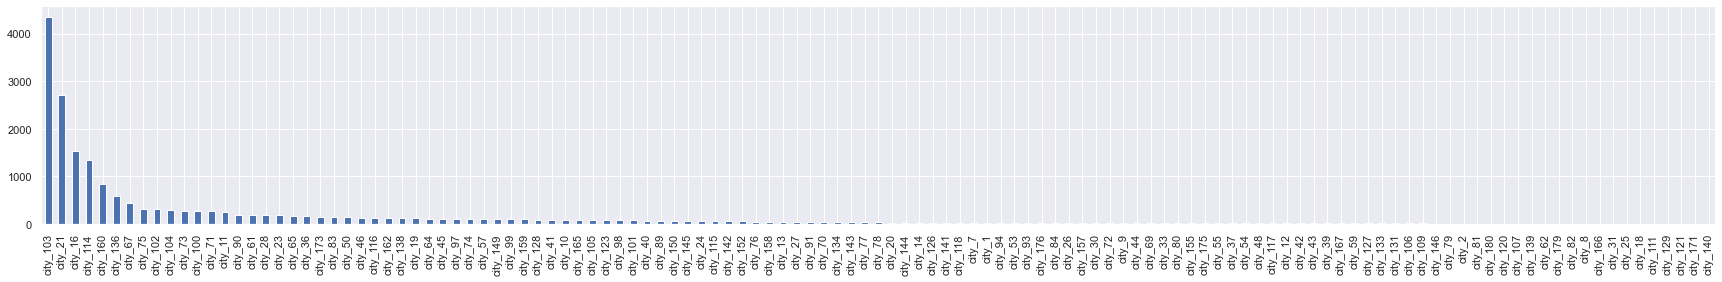

In [15]:
f,ax=plt.subplots(figsize=(30,4))
print(df['city'].value_counts())
df['city'].value_counts().plot(kind='bar')

count     123.000000
mean      155.756098
std       493.999276
min         1.000000
25%        13.000000
50%        31.000000
75%       104.000000
max      4355.000000
Name: city, dtype: float64


<AxesSubplot:xlabel='city'>

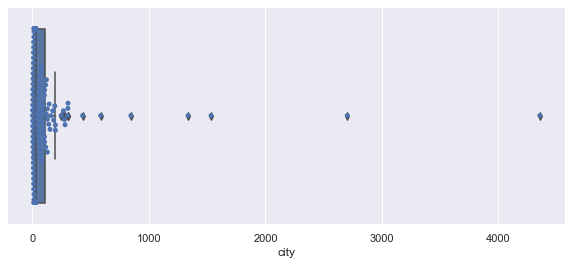

In [16]:
print(df['city'].value_counts().describe())
f,ax=plt.subplots(figsize=(10,4))
sns.boxplot(x=df['city'].value_counts())
sns.swarmplot(x=df['city'].value_counts())

city
city_98     0.949
city_75     0.939
city_28     0.939
city_114    0.926
city_89     0.925
            ...  
city_179    0.512
city_48     0.493
city_139    0.487
city_126    0.479
city_33     0.448
Name: city_development_index, Length: 123, dtype: float64


<AxesSubplot:xlabel='city'>

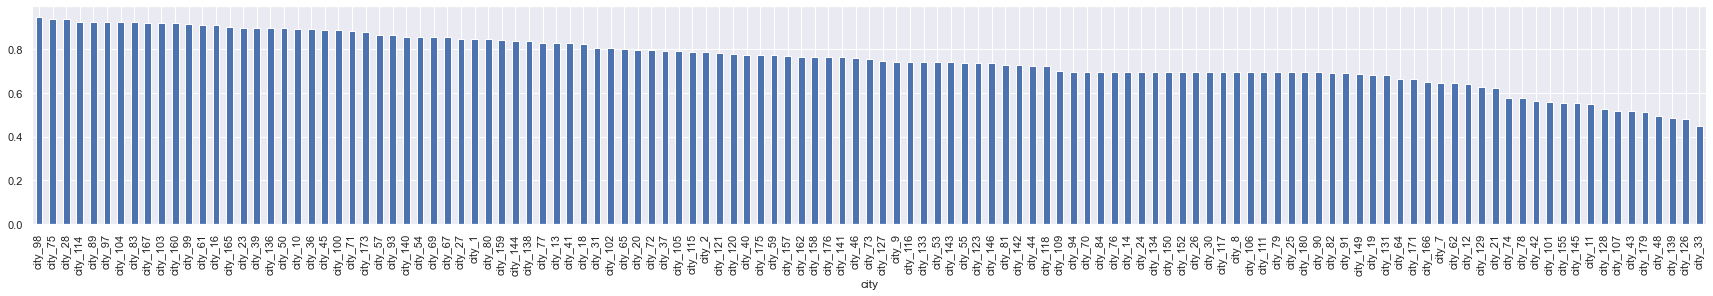

In [17]:
f,ax=plt.subplots(figsize=(30,4))
df_city_dev = df.groupby('city')['city_development_index'].mean()
print(df_city_dev.sort_values(ascending=False))
df_city_dev.sort_values(ascending=False).plot(kind='bar')

count    19158.000000
mean         0.828848
std          0.123362
min          0.448000
25%          0.740000
50%          0.903000
75%          0.920000
max          0.949000
Name: city_development_index, dtype: float64


<AxesSubplot:xlabel='city_development_index'>

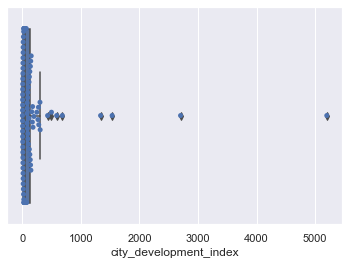

In [18]:
print(df['city_development_index'].describe())
sns.boxplot(x=df['city_development_index'].value_counts())
sns.swarmplot(x=df['city_development_index'].value_counts())


In [19]:
encoder = LabelEncoder()
df['city'] = encoder.fit_transform(df['city'])

In [20]:
df['city'].head()

0     5
1    77
2    64
3    14
4    50
Name: city, dtype: int32

## target 별 시각화 

In [21]:
ndf  = df[df['target']==0]
pdf  = df[df['target']==1]

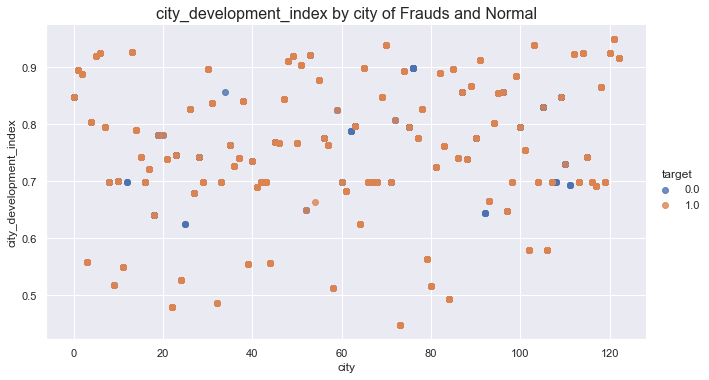

In [22]:
ax = sns.lmplot(y="city_development_index", x="city", fit_reg=False, aspect=1.8, data=df, hue='target')
plt.title("city_development_index by city of Frauds and Normal", fontsize=16)
plt.show()

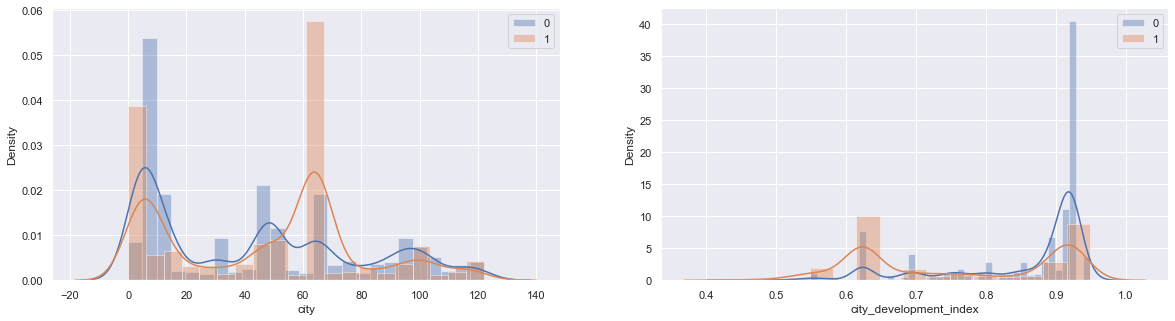

In [23]:
fig, axes = plt.subplots(1,2,figsize=(20,5))
sns.plot(ndf['city'], label="0" ,ax=axes[0])
sns.distplot(pdf['city'], label="1" ,ax=axes[0])
axes[0].legend()

sns.distplot(ndf['city_development_index'], label="0" ,ax=axes[1])
sns.distplot(pdf['city_development_index'], label="1" ,ax=axes[1])
axes[1].legend()

plt.show()

### 교육 관련 피쳐
* 'enrolled_university': 대학과정
* 'education_level': 교육수준
* 'major_discipline': 전공
* 'training_hours': 교육 이수 시간

In [24]:
edu_cols = ['enrolled_university','education_level','major_discipline','training_hours']
for col in edu_cols:
    print(df[col].value_counts())
    print(df[col].unique().tolist())
    print("-"*20)
    
dict = {'no_enrollment':0, 'Part time course':1, 'Full time course':2}
df['enrolled_university'] = df['enrolled_university'].map(dict)

dict = { 'Primary School':0, 'High School':1, 'Graduate':2, 'Masters':3, 'Phd':4}
df['education_level'] = df['education_level'].map(dict)

dict = {'STEM':0, 'Business Degree':1, 'Arts':2, 'Humanities':3,'Other':4,  'No Major':5 }
df['major_discipline'] = df['major_discipline'].map(dict)

df['training_hours'] = pd.cut(df['training_hours'], bins=[0,18,43,123,280,400], labels=[0,1,2,3,4]).astype('float32')

no_enrollment       13817
Full time course     3757
Part time course     1198
Name: enrolled_university, dtype: int64
['no_enrollment', 'Full time course', nan, 'Part time course']
--------------------
Graduate          11598
Masters            4361
High School        2017
Phd                 414
Primary School      308
Name: education_level, dtype: int64
['Graduate', 'Masters', 'High School', nan, 'Phd', 'Primary School']
--------------------
STEM               14492
Humanities           669
Other                381
Business Degree      327
Arts                 253
No Major             223
Name: major_discipline, dtype: int64
['STEM', 'Business Degree', nan, 'Arts', 'Humanities', 'No Major', 'Other']
--------------------
28     329
12     292
18     291
22     282
50     279
      ... 
266      6
286      5
272      5
234      5
238      4
Name: training_hours, Length: 241, dtype: int64
[36, 47, 83, 52, 8, 24, 18, 46, 123, 32, 108, 23, 26, 106, 7, 132, 68, 50, 48, 65, 13, 22, 148, 72,

## target 별 시각화 

In [25]:
ndf  = df[df['target']==0]
pdf  = df[df['target']==1]

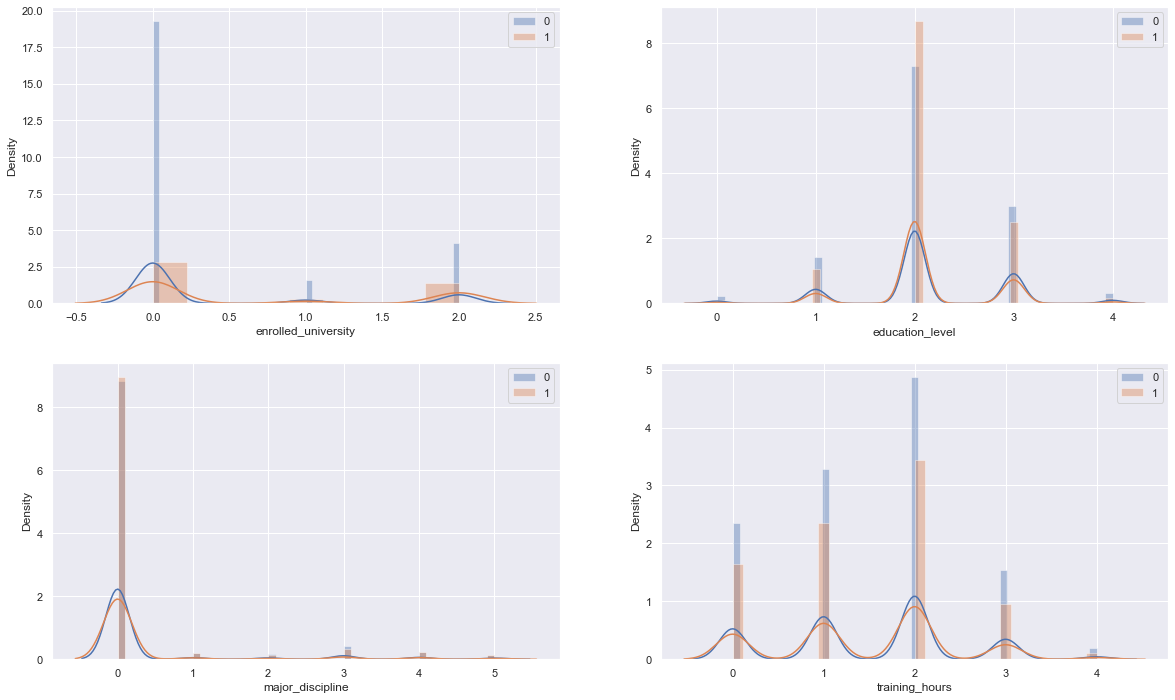

In [26]:
#  ['enrolled_university','education_level','major_discipline','training_hours']

fig, axes = plt.subplots(2,2,figsize=(20,12))
sns.distplot(ndf['enrolled_university'], label="0" ,ax=axes[0][0])
sns.distplot(pdf['enrolled_university'], label="1" ,ax=axes[0][0])
axes[0][0].legend()

sns.distplot(ndf['education_level'], label="0" ,ax=axes[0][1])
sns.distplot(pdf['education_level'], label="1" ,ax=axes[0][1])
axes[0][1].legend()

sns.distplot(ndf['major_discipline'], label="0" ,ax=axes[1][0])
sns.distplot(pdf['major_discipline'], label="1" ,ax=axes[1][0])
axes[1][0].legend()

sns.distplot(ndf['training_hours'], label="0" ,ax=axes[1][1])
sns.distplot(pdf['training_hours'], label="1" ,ax=axes[1][1])
axes[1][1].legend()

plt.show()

In [27]:
print(ndf['education_level'].describe())
print(pdf['education_level'].describe())

count    14025.000000
mean         2.141248
std          0.719561
min          0.000000
25%          2.000000
50%          2.000000
75%          3.000000
max          4.000000
Name: education_level, dtype: float64
count    4673.000000
mean        2.123047
std         0.595044
min         0.000000
25%         2.000000
50%         2.000000
75%         2.000000
max         4.000000
Name: education_level, dtype: float64


### 이변량분석
*  { 'Primary School':0, 'High School':1, 'Graduate':2, 'Masters':3, 'Phd':4}

enrolled_university   0.0  1.0   2.0
education_level                     
0.0                   255   11    33
1.0                   940  166   864
2.0                  8434  784  2209
3.0                  3547  204   557
4.0                   371   12    25


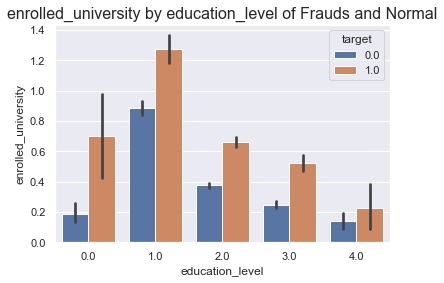

In [28]:
print(  pd.crosstab(df['education_level'], df['enrolled_university']) )   # {'no_enrollment':0, 'Part time course':1, 'Full time course':2}
ax = sns.barplot(y="enrolled_university", x="education_level", data=df, hue='target')
plt.title("enrolled_university by education_level of Frauds and Normal", fontsize=16)
plt.show()

major_discipline    0.0  1.0  2.0  3.0  4.0  5.0
education_level                                 
2.0               10244  238  208  420  272  194
3.0                3873   86   42  225  100   29
4.0                 375    3    3   24    9    0


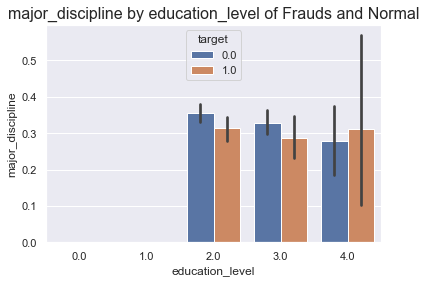

In [29]:
print(  pd.crosstab(df['education_level'], df['major_discipline']) )    #{'STEM':0, 'Business Degree':1, 'Arts':2, 'Humanities':3,'Other':4,  'No Major':5 }
ax = sns.barplot(y="major_discipline", x="education_level", data=df, hue='target')
plt.title("major_discipline by education_level of Frauds and Normal", fontsize=16)
plt.show() 

training_hours    0.0   1.0   2.0   3.0  4.0
education_level                             
0.0                85    73   105    40    5
1.0               359   535   847   249   27
2.0              2207  3156  4611  1444  180
3.0               866  1191  1754   493   57
4.0                89   108   148    61    8


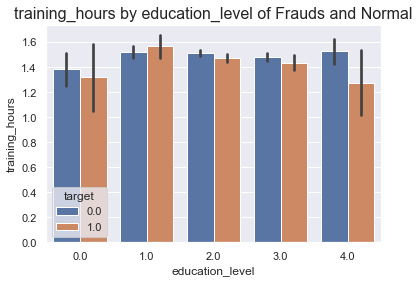

In [30]:
print(  pd.crosstab(df['education_level'], df['training_hours']) )    # bins=[0,18,43,123,280,400], labels=[0,1,2,3,4]
ax = sns.barplot(y="training_hours", x="education_level", data=df, hue='target')
plt.title("training_hours by education_level of Frauds and Normal", fontsize=16)
plt.show() 

### 경력 관련 피쳐
* 'relevent_experience': 관련경험
* 'experience':경력(년)
* 'last_new_job': 현재 직업 경력(년)

In [31]:
job_cols = ['last_new_job','experience','relevent_experience']
for col in job_cols:
    print(df[col].value_counts())
    print(df[col].unique().tolist())
    print("-"*20)
    
dict = {'never':0, '1':1,'2':2,  '3':3, '4':4,'>4':5}
df['last_new_job'] = df['last_new_job'].map(dict)

dict = {'<1':0, '1':1, '2':2, '3':3, '4':4,  '5':5,'6':6,'7':7, '8':8, '9':9,  '10':10,'11':11,'12':12, '13':13,'14':14, '15':15, '16':16, '17':17, '18':18,'19':19, '20':20,'>20':21}
df['experience'] = df['experience'].map(dict)
        
dict = {'No relevent experience':0,'Has relevent experience':1}
df['relevent_experience'] = df['relevent_experience'].map(dict)

1        8040
>4       3290
2        2900
never    2452
4        1029
3        1024
Name: last_new_job, dtype: int64
['1', '>4', 'never', '4', '3', '2', nan]
--------------------
>20    3286
5      1430
4      1403
3      1354
6      1216
2      1127
7      1028
10      985
9       980
8       802
15      686
11      664
14      586
1       549
<1      522
16      508
12      494
13      399
17      342
19      304
18      280
20      148
Name: experience, dtype: int64
['>20', '15', '5', '<1', '11', '13', '7', '17', '2', '16', '1', '4', '10', '14', '18', '19', '12', '3', '6', '9', '8', '20', nan]
--------------------
Has relevent experience    13792
No relevent experience      5366
Name: relevent_experience, dtype: int64
['Has relevent experience', 'No relevent experience']
--------------------


## target 별 시각화 

In [32]:
ndf  = df[df['target']==0]
pdf  = df[df['target']==1]

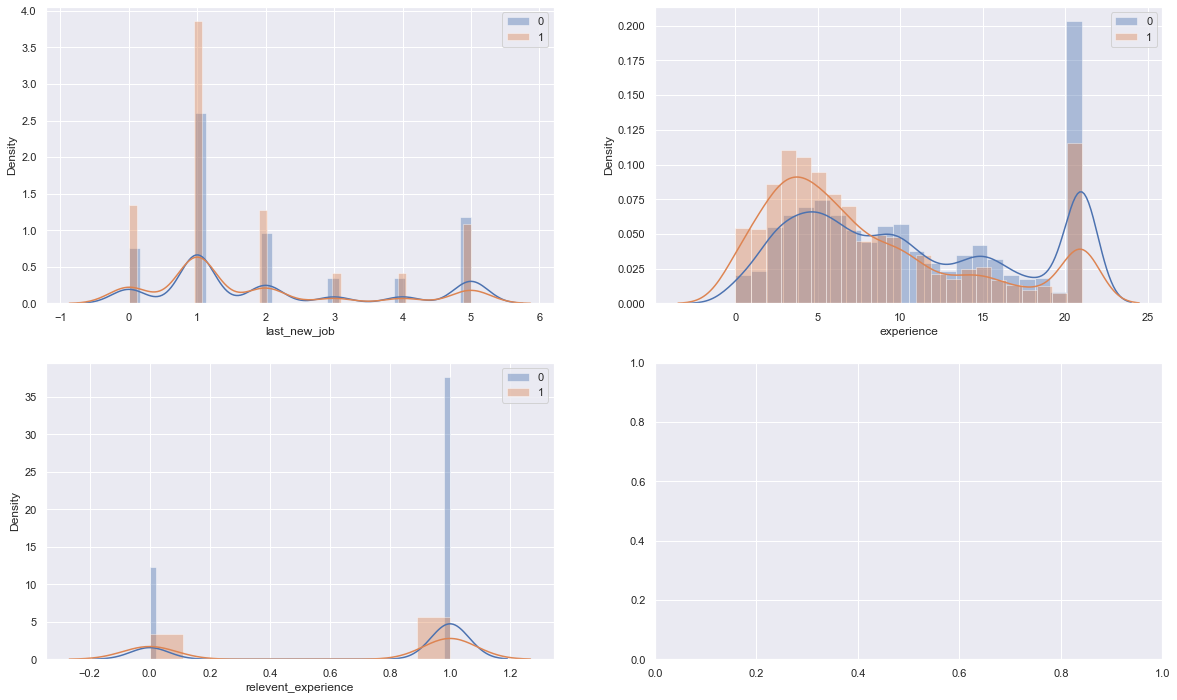

In [33]:
# ['last_new_job','experience','relevent_experience']

fig, axes = plt.subplots(2,2,figsize=(20,12))
sns.distplot(ndf['last_new_job'], label="0" ,ax=axes[0][0])
sns.distplot(pdf['last_new_job'], label="1" ,ax=axes[0][0])
axes[0][0].legend()

sns.distplot(ndf['experience'], label="0" ,ax=axes[0][1])
sns.distplot(pdf['experience'], label="1" ,ax=axes[0][1])
axes[0][1].legend()

sns.distplot(ndf['relevent_experience'], label="0" ,ax=axes[1][0])
sns.distplot(pdf['relevent_experience'], label="1" ,ax=axes[1][0])
axes[1][0].legend()

plt.show()

### 이변량분석
*  ['last_new_job','experience','relevent_experience']

In [34]:
pd.crosstab(df['target'], df['last_new_job'])   #{'never':0, '1':1,'2':2,  '3':3, '4':4,'>4':5}

last_new_job,0.0,1.0,2.0,3.0,4.0,5.0
target,,,,,,
0.0,1713,5915,2200,793,801,2690
1.0,739,2125,700,231,228,600


In [35]:
pd.crosstab(df['target'], df['experience']).T   #  {'<1':0, '1':1, '2':2, '3':3, '4':4,  '5':5,'6':6,'7':7, '8':8, '9':9,  '10':10,'11':11,'12':12, '13':13,'14':14, '15':15, '16':16, '17':17, '18':18,'19':19, '20':20,'>20':21}

target,0.0,1.0
experience,,
0.0,285,237
1.0,316,233
2.0,753,374
3.0,876,478
4.0,946,457
5.0,1018,412
6.0,873,343
7.0,725,303
8.0,607,195


In [36]:
pd.crosstab(df['target'], df['relevent_experience'])    # {'No relevent experience':0,'Has relevent experience':1}

relevent_experience,0,1
target,,
0.0,3550,10831
1.0,1816,2961


In [37]:
pd.crosstab([df['experience'], df['relevent_experience']], df['target'])

target                           0.0  1.0
experience relevent_experience           
0.0        0                     203  155
           1                      82   82
1.0        0                     211  148
           1                     105   85
2.0        0                     448  244
           1                     305  130
3.0        0                     455  254
           1                     421  224
4.0        0                     383  215
           1                     563  242
5.0        0                     337  173
           1                     681  239
6.0        0                     221  112
           1                     652  231
7.0        0                     165  105
           1                     560  198
8.0        0                     120   51
           1                     487  144
9.0        0                     140   62
           1                     627  151
10.0       0                     115   60
           1                     663  147
11.0       0                      72   28
           1                     441  123
12.0       0                      43   18
           1                     359   74
13.0       0                      39   16
           1                     283   61
14.0       0                      62   25
           1                     417   82
15.0       0                      68   31
           1                     504   83
16.0       0                      38   14
           1                     398   58
17.0       0                      22    6
           1                     263   51
18.0       0                      22    5
           1                     215   38
19.0       0                      32    8
           1                     219   45
20.0       0                      11    5
           1                     104   28
21.0       0                     329   74
           1                    2454  429

## 소속회사 관련 피쳐 
* 'company_size': 소속회사 직원수
* 'company_type': 소속회사 유형

####  company_size 구간화
<pre>
<10          1308
10/49        1471
50-99        3083
100-500      2571
500-999       877
1000-4999    1328
5000-9999     563
10000+       2019
</pre>

In [38]:
dict = {'<10':1, '10/49':2, '50-99':3, '100-500':4, '500-999':5, '1000-4999':6, '5000-9999':7, '10000+':8}
df['company_size'] = df['company_size'].map(dict)
df['company_size'].value_counts()

3.0    3083
4.0    2571
8.0    2019
2.0    1471
6.0    1328
1.0    1308
5.0     877
7.0     563
Name: company_size, dtype: int64

<AxesSubplot:xlabel='company_size', ylabel='count'>

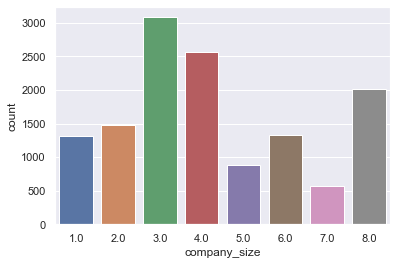

In [39]:
# df['company_size2'].hist()
sns.countplot('company_size',data=df)

#### company_type

In [40]:
dict = {'Pvt Ltd':1,'Funded Startup':2,'Public Sector':3,'Early Stage Startup':4,'NGO':5,'Other':6}
df['company_type'] = df['company_type'].map(dict)
df['company_type'].head()

0    NaN
1    1.0
2    NaN
3    1.0
4    2.0
Name: company_type, dtype: float64

In [41]:
df['company_type'].describe()

count    13018.000000
mean         1.569135
std          1.155907
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          6.000000
Name: company_type, dtype: float64

<AxesSubplot:xlabel='company_type', ylabel='count'>

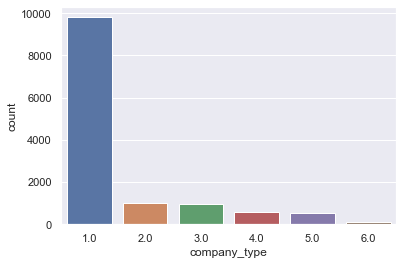

In [42]:
sns.countplot('company_type',data=df)

#### company_type 별 company_size 평균

In [43]:
df.groupby("company_type")['company_size'].mean()

company_type
1.0    4.498459
2.0    2.840201
3.0    5.146489
4.0    1.805000
5.0    4.341414
6.0    4.371681
Name: company_size, dtype: float64

## target 별 시각화 

In [44]:
ndf  = df[df['target']==0]
pdf  = df[df['target']==1]

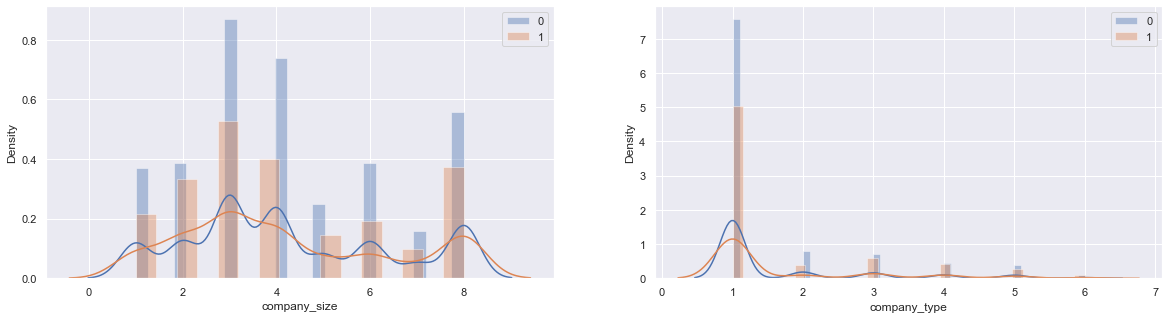

In [45]:
# ['company_size','company_type']

fig, axes = plt.subplots(1,2,figsize=(20,5))
sns.distplot(ndf['company_size'], label="0" ,ax=axes[0])
sns.distplot(pdf['company_size'], label="1" ,ax=axes[0])
axes[0].legend()

sns.distplot(ndf['company_type'], label="0" ,ax=axes[1])
sns.distplot(pdf['company_type'], label="1" ,ax=axes[1])
axes[1].legend()

plt.show()


### 이변량분석
*  ['company_size','company_type']

company_type   1.0  2.0  3.0  4.0  5.0  6.0
company_size                               
1.0            728  144   35  286   36   14
2.0            910  193   43  176   32   12
3.0           2151  390  116  109   77   18
4.0           1833  214  151   27  174   20
5.0            622   54   87    2   37   11
6.0           1016    0  165    0   73   15
7.0            412    0   79    0   29    7
8.0           1739    0  150    0   37   16


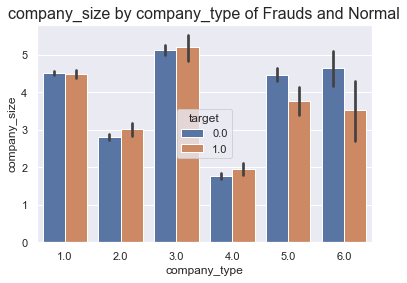

In [46]:
print(  pd.crosstab(df['company_size'], df['company_type']) )    #{'STEM':0, 'Business Degree':1, 'Arts':2, 'Humanities':3,'Other':4,  'No Major':5 }
                                                                 #{'<10':1, '10/49':2, '50-99':3, '100-500':4, '500-999':5, '1000-4999':6, '5000-9999':7, '10000+':8}
ax = sns.barplot(y="company_size", x="company_type", data=df, hue='target')
plt.title("company_size by company_type of Frauds and Normal", fontsize=16)
plt.show() 

### 성별 피쳐

In [47]:
dict = {'Male':1, 'Female':2, 'Other':3}
df['gender'] = df['gender'].map(dict)
df['gender'].value_counts()

1.0    13221
2.0     1238
3.0      191
Name: gender, dtype: int64

## target 별 시각화 

In [48]:
ndf  = df[df['target']==0]
pdf  = df[df['target']==1]

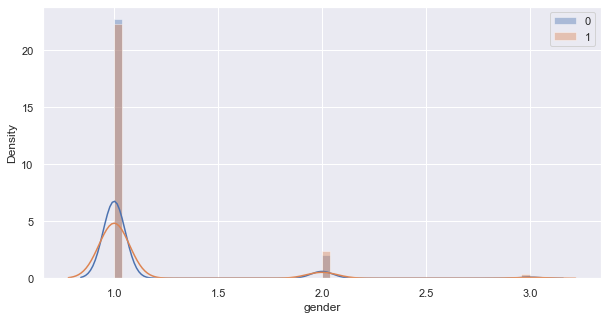

In [49]:
# ['gender']

fig, axes = plt.subplots(figsize=(10,5))
sns.distplot(ndf['gender'], label="0" )
sns.distplot(pdf['gender'], label="1" )
axes.legend()

plt.show()


# 결측처리

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  int32  
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  float64
 4   relevent_experience     19158 non-null  int64  
 5   enrolled_university     18772 non-null  float64
 6   education_level         18698 non-null  float64
 7   major_discipline        16345 non-null  float64
 8   experience              19093 non-null  float64
 9   company_size            13220 non-null  float64
 10  company_type            13018 non-null  float64
 11  last_new_job            18735 non-null  float64
 12  training_hours          19158 non-null  float32
 13  target                  19158 non-null  float64
dtypes: float32(1), float64(10), int32(1), 

In [51]:
df.isna().sum().sort_values(ascending=False)

company_type              6140
company_size              5938
gender                    4508
major_discipline          2813
education_level            460
last_new_job               423
enrolled_university        386
experience                  65
enrollee_id                  0
city                         0
city_development_index       0
relevent_experience          0
training_hours               0
target                       0
dtype: int64

* company_type2 결측처리 : 최빈도 1값으로 처리 

* company_size2 결측처리  : company_type2 그룹별 company_size2 평균값

In [52]:
df['company_type'] = df['company_type'].fillna(df['company_type'].mode()[0])
df['company_size'] = df['company_size'].fillna( df.groupby("company_type")['company_size'].transform('mean') )

In [53]:
df[['company_type','company_size']].isna().sum()

company_type    0
company_size    0
dtype: int64

In [54]:
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,5,0.920,1.0,1,0.0,2.0,0.0,21.0,4.457462,1.0,1.0,1.0,1.0
1,29725,77,0.776,1.0,0,0.0,2.0,0.0,15.0,3.000000,1.0,5.0,2.0,0.0
2,11561,64,0.624,NaN,0,2.0,2.0,0.0,5.0,4.457462,1.0,0.0,2.0,0.0
3,33241,14,0.789,NaN,0,NaN,2.0,1.0,0.0,4.457462,1.0,0.0,2.0,1.0
4,666,50,0.767,1.0,1,0.0,3.0,0.0,21.0,3.000000,2.0,4.0,0.0,0.0


### pd.get_dummies() 소개

In [55]:
# ## 결측처리(0,'')  + LabelEncoding() + OneHotEncoding()
# df22 = pd.get_dummies(df[['gender','education_level']])
# print(df22.info())
# df22.head()

### LabelEncoder() 소개

In [56]:
# from sklearn.preprocessing import LabelEncoder
# encoder = LabelEncoder()
# data = ["f", "m","o", np.nan]
# res_encoder = encoder.fit_transform(data)
# print(res_encoder)  #[0 1 2]
# original_data = encoder.inverse_transform(res_encoder)
# print(original_data)

### gender 결측처리 : 최빈도 (Male) 값

In [57]:
df['gender'] = df['gender'].fillna(df['gender'].mode()[0])
df['gender'].isna().sum()

0

<AxesSubplot:>

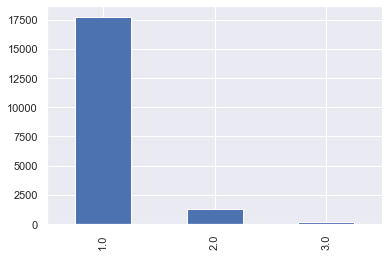

In [58]:
df['gender'].value_counts().plot(kind='bar')

## 상관분석
* 두 피쳐간의 선형관계 (-1.0~1.0)
  + - 0.3~ 0.7: 강한상관
  + - 0.7~ 1.0: 매우~~ 강한상관(0.8이상 다중공선)
* 다중공선성 해결방법 : drop, PCA(차원축소)

<AxesSubplot:>

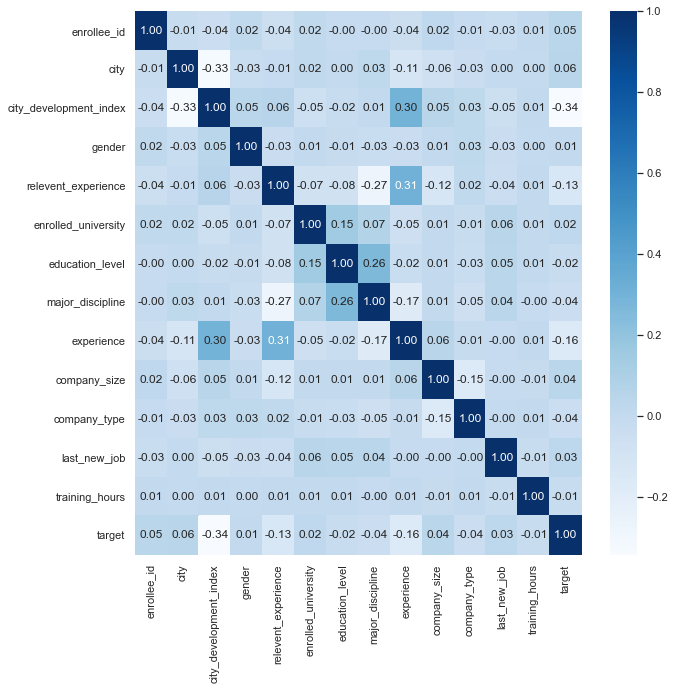

In [59]:
df2 = df.copy()
for col in obj_cols:
    encoder = LabelEncoder()
    df2[col] = encoder.fit_transform(df2[col])

fig, ax = plt.subplots(figsize=(10,10))     
sns.heatmap(df2.corr(), annot=True, fmt=".2f", cmap="Blues")

target 피쳐와 (+) 상관관계 TOP-n Index(['target', 'enrolled_university', 'city', 'enrollee_id', 'gender'], dtype='object')
target 피쳐와 (-) 상관관계 TOP-n Index(['city_development_index', 'experience', 'relevent_experience',
       'last_new_job', 'company_type'],
      dtype='object')


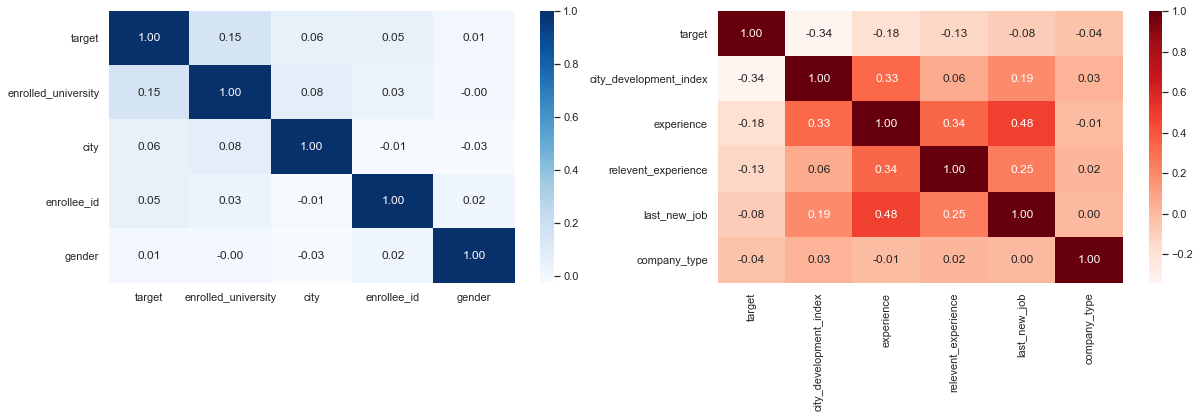

In [60]:
#### target에 영향을 주는 상위 n개 피쳐에 대해서만 상관 분석
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))

top_corr_large  = df.corr().nlargest(5, 'target').index
print("target 피쳐와 (+) 상관관계 TOP-n", top_corr_large)
sns.heatmap(df[top_corr_large].corr(), annot=True, cmap='Blues', fmt='0.2f' , ax=ax1)

top_corr_small = df.corr().nsmallest(5, 'target').index
print("target 피쳐와 (-) 상관관계 TOP-n", top_corr_small)
sns.heatmap(df[['target','city_development_index', 'experience', 'relevent_experience','last_new_job', 'company_type']].corr(), annot=True, cmap='Reds', fmt='0.2f' , ax=ax2)
plt.show()

* enrolled_university - relevenet_experience  : -.35 (약 음 상관관계)
* company_type - company_size  : .34 (약 양 상관관계)
* relevent_experience - company_size : 0.34 (약 양 상관관계)

In [61]:
print(df2.corr().nlargest(5, 'target').index)
print(df2.corr().nsmallest(5, 'target').index)    

Index(['target', 'city', 'enrollee_id', 'company_size', 'last_new_job'], dtype='object')
Index(['city_development_index', 'experience', 'relevent_experience',
       'major_discipline', 'company_type'],
      dtype='object')


#### 'enrolled_university': 대학과정  'relevent_experience': 관련경험

In [62]:
# sns.pairplot(df2[['enrolled_university','relevent_experience']])

In [63]:
for col in nan_cols : 
    print(col , df[col].unique().tolist())  #'Male', nan, 'Female', 'Other'
    print("--"*20)
    print(df[col].value_counts())
    print("--"*20)

# 수치형 변환 시 레벨 유지 불필요 --> 원핫인코딩 -------------------------    
# gender ['Male', nan, 'Female', 'Other']
# major_discipline ['STEM', 'Business Degree', nan, 'Arts', 'Humanities', 'No Major', 'Other']

# 수치형 변환 시 레벨 유지해야 할 피쳐 -----------------------------------
# education_level ['Primary School', 'High School', 'Graduate', 'Masters', 'Phd', nan  ]
# enrolled_university ['no_enrollment', 'Full time course', nan, 'Part time course']
# last_new_job ['1', '>4', 'never', '4', '3', '2', nan]
# experience ['>20', '15', '5', '<1', '11', '13', '7', '17', '2', '16', '1', '4', '10', '14', '18', '19', '12', '3', '6', '9', '8', '20', nan]

company_type [1.0, 2.0, 4.0, 6.0, 3.0, 5.0]
----------------------------------------
1.0    15957
2.0     1001
3.0      955
4.0      603
5.0      521
6.0      121
Name: company_type, dtype: int64
----------------------------------------
company_size [4.457462466882544, 3.0, 1.0, 8.0, 7.0, 6.0, 2.0, 4.0, 5.0, 5.146489104116223, 4.341414141414141, 1.805, 2.8402010050251256, 4.371681415929204]
----------------------------------------
4.457462    5766
3.000000    3083
4.000000    2571
8.000000    2019
2.000000    1471
6.000000    1328
1.000000    1308
5.000000     877
7.000000     563
5.146489     129
4.341414      26
4.371681       8
2.840201       6
1.805000       3
Name: company_size, dtype: int64
----------------------------------------
gender [1.0, 2.0, 3.0]
----------------------------------------
1.0    17729
2.0     1238
3.0      191
Name: gender, dtype: int64
----------------------------------------
major_discipline [0.0, 1.0, nan, 2.0, 3.0, 5.0, 4.0]
-----------------------------

## 결측처리  : 최빈도 값으로 채우기
<pre>
company_type : Pvt Ltd 
company_size : company_type 그룹별 평균
gender  : 'Male'
major_discipline : 'STEM'
education_level : 'Graduate'
last_new_job : '1'
enrolled_university : 'no_enrollment'
experience: '>20'  
</pre>

In [64]:
for col in nan_cols : 
    df[col].fillna(df[col].mode()[0], inplace=True)    

### 문자형 --> 수치형 변환 (LabelEncoding)

In [65]:
for col in obj_cols:
    encoder = LabelEncoder()
    df[col] = encoder.fit_transform(df[col])

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  int64  
 2   city_development_index  19158 non-null  float64
 3   gender                  19158 non-null  int64  
 4   relevent_experience     19158 non-null  int64  
 5   enrolled_university     19158 non-null  int64  
 6   education_level         19158 non-null  int64  
 7   major_discipline        19158 non-null  int64  
 8   experience              19158 non-null  int64  
 9   company_size            19158 non-null  int64  
 10  company_type            19158 non-null  int64  
 11  last_new_job            19158 non-null  int64  
 12  training_hours          19158 non-null  float32
 13  target                  19158 non-null  float64
dtypes: float32(1), float64(2), int64(11)
m

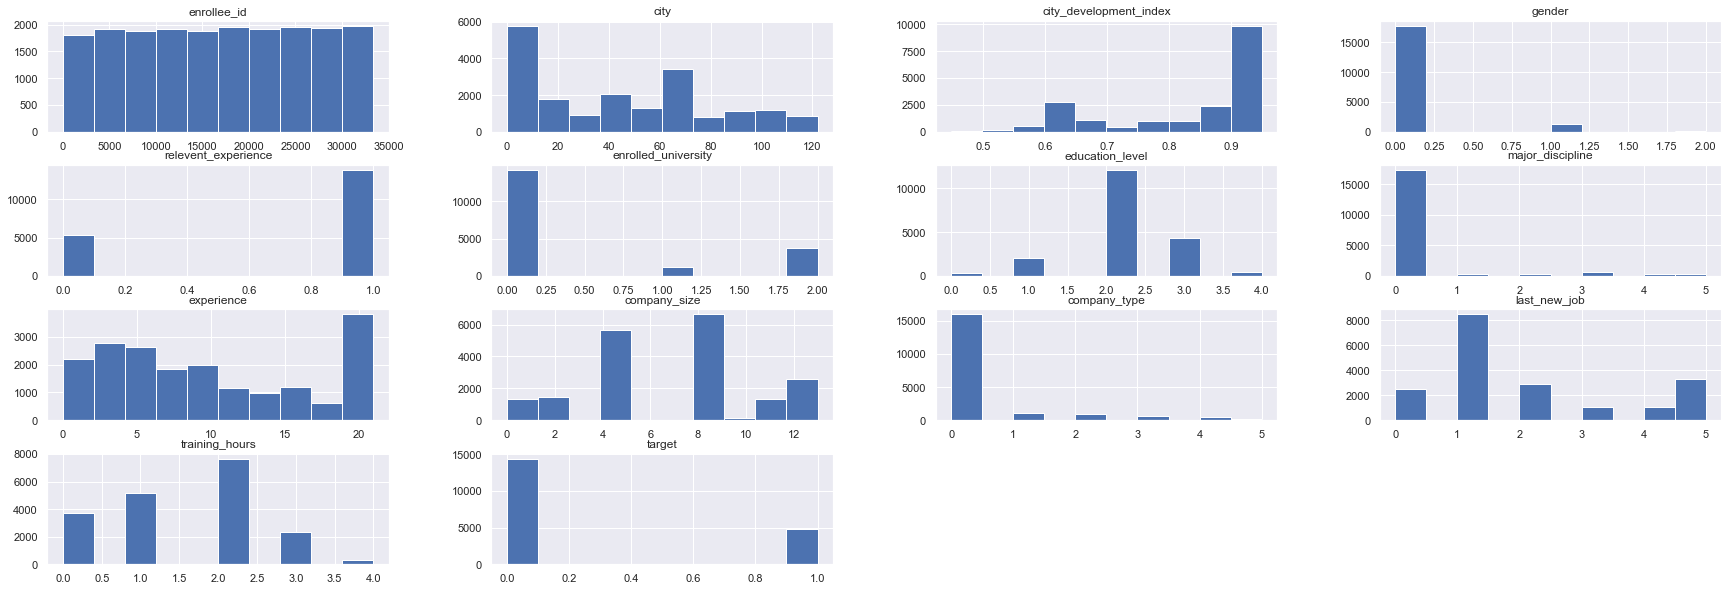

In [67]:
df.hist(figsize=(30, 10))
plt.show()

#### 가공이 끝난 피쳐 삭제

In [68]:
del_cols = ['enrollee_id']
df = df.drop(del_cols, axis=1)

In [69]:
df.shape

(19158, 13)

In [70]:
# df = pd.get_dummies(df, columns=['gender','major_discipline'], drop_first=True)

In [71]:
df.shape

(19158, 13)

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    19158 non-null  int64  
 1   city_development_index  19158 non-null  float64
 2   gender                  19158 non-null  int64  
 3   relevent_experience     19158 non-null  int64  
 4   enrolled_university     19158 non-null  int64  
 5   education_level         19158 non-null  int64  
 6   major_discipline        19158 non-null  int64  
 7   experience              19158 non-null  int64  
 8   company_size            19158 non-null  int64  
 9   company_type            19158 non-null  int64  
 10  last_new_job            19158 non-null  int64  
 11  training_hours          19158 non-null  float32
 12  target                  19158 non-null  float64
dtypes: float32(1), float64(2), int64(10)
memory usage: 1.8 MB


In [73]:
df[['target','company_type','training_hours']] = df[['target','company_type','training_hours']].astype('int')
df.head()

,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,5,0.920,0,1,0,2,0,21,8,0,1,1,1
1,77,0.776,0,0,0,2,0,15,4,0,5,2,0
2,64,0.624,0,0,2,2,0,5,8,0,0,2,0
3,14,0.789,0,0,0,2,1,0,8,0,0,2,1
4,50,0.767,0,1,0,3,0,21,4,1,4,0,0


## 분석모델

In [74]:
y = df['target']
X = df.drop('target', axis=1)
model = RandomForestClassifier(n_estimators=300,random_state=1414) 
# model = DecisionTreeClassifier() 

정확도0.7790 정밀도:0.5624 재현률:0.4457 f1:0.4973
오차행렬
 [[2566  326]
 [ 521  419]]


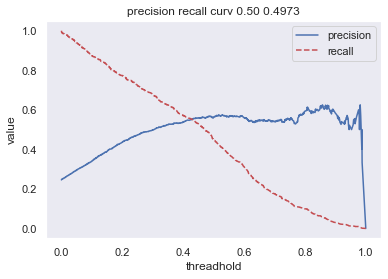

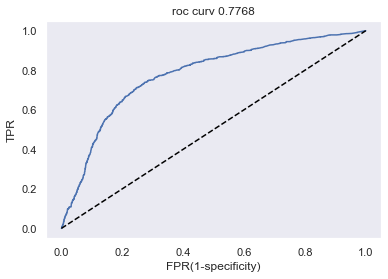

In [75]:
split_fit_score(X, y, model)   #0.4955  #0.4973

## model feature_importances_

                       col       imp
1   city_development_index  0.190220
7               experience  0.187141
8             company_size  0.134418
0                     city  0.113359
11          training_hours  0.093478
10            last_new_job  0.089232
5          education_level  0.056458
4      enrolled_university  0.036681
9             company_type  0.029285
6         major_discipline  0.025589
3      relevent_experience  0.023689
2                   gender  0.020450


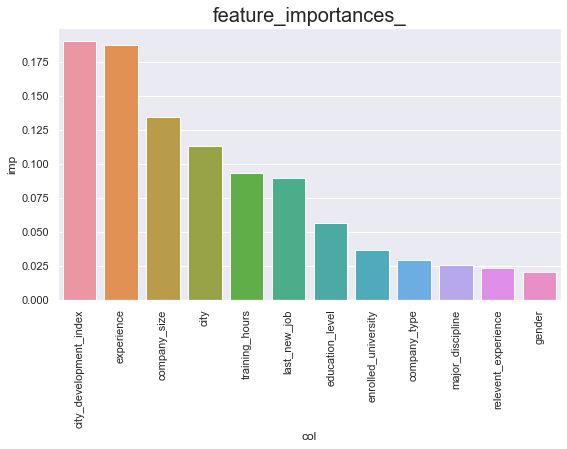

In [87]:
plt.figure(figsize = (9,5))

imp_df = pd.DataFrame({'col': X.columns, 'imp': model.feature_importances_})
imp_df = imp_df.sort_values(by='imp',ascending=False)
print(imp_df)

g = sns.barplot(x='col',y='imp',data=imp_df)
g.set_xticklabels(g.get_xticklabels(),rotation=90)
g.set_title('feature_importances_',fontsize=20)
plt.show() 

In [90]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
# from catboost import Pool, CatBoostClassifier, cv
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

=========1차 평가 : 불균형 데이터 ======= ******************************
RandomForestClassifier
정확도0.7777 정밀도:0.5656 재현률:0.4649 f1:0.5103
오차행렬
 [[2536  341]
 [ 511  444]]


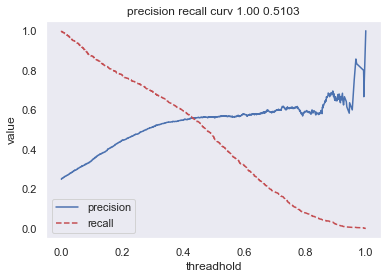

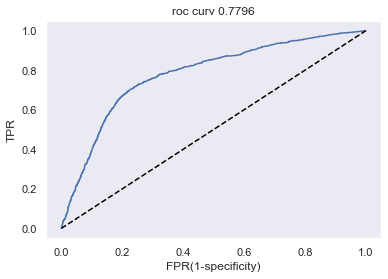

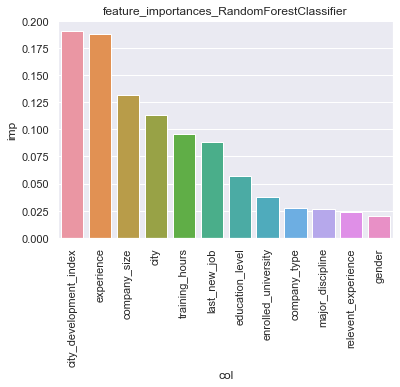

LGBMClassifier
정확도0.7949 정밀도:0.5900 재현률:0.5801 f1:0.5850
오차행렬
 [[2492  385]
 [ 401  554]]


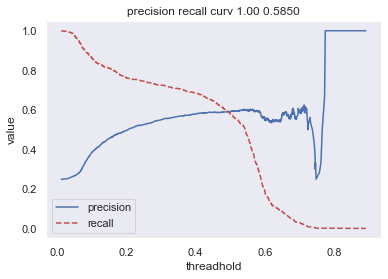

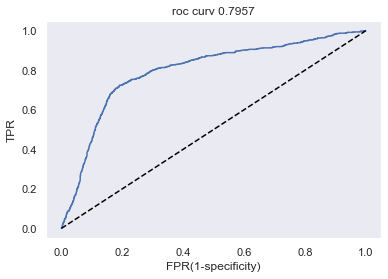

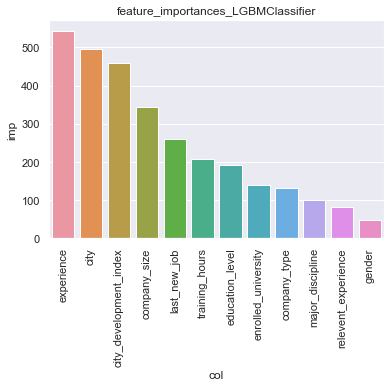

[03:33:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier
정확도0.7795 정밀도:0.5632 재현률:0.5131 f1:0.5370
오차행렬
 [[2497  380]
 [ 465  490]]


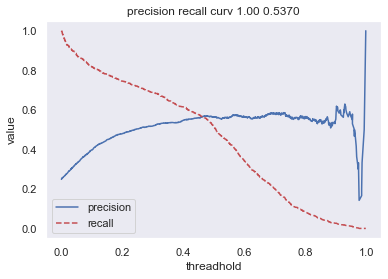

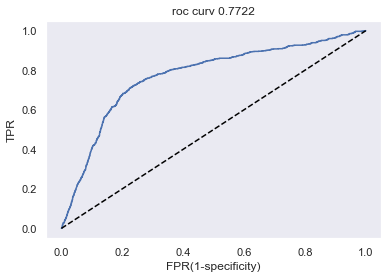

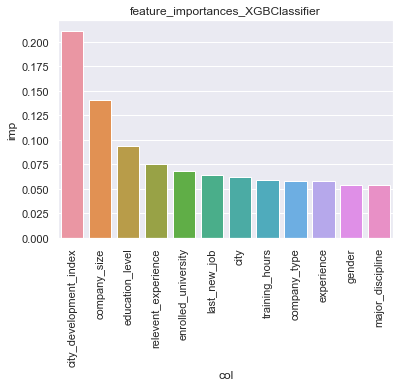

=========2차 평가 : SMOTE 오버샘플링 ======= ******************************
SMOTE 적용 전 : ((15326, 12), (15326,))
SMOTE 적용 후 : ((23008, 12), (23008,))
0    11504
1    11504
Name: target, dtype: int64
RandomForestClassifier
정확도0.7649 정밀도:0.5240 재현률:0.6168 f1:0.5666
오차행렬
 [[2342  535]
 [ 366  589]]


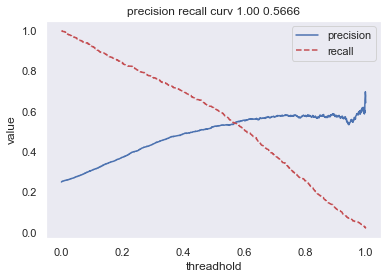

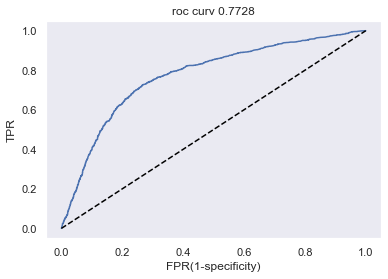

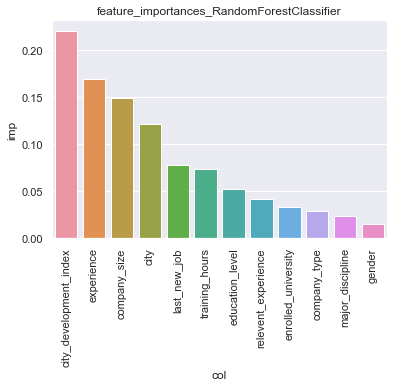

LGBMClassifier
정확도0.7777 정밀도:0.5406 재현률:0.7183 f1:0.6169
오차행렬
 [[2294  583]
 [ 269  686]]


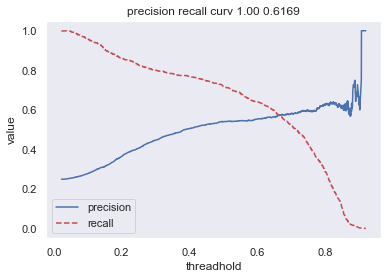

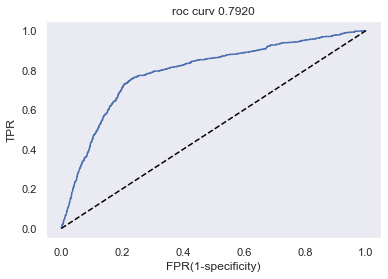

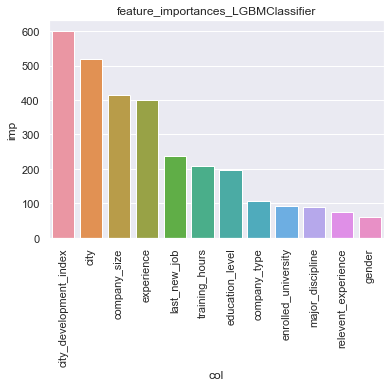

[03:33:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier
정확도0.7771 정밀도:0.5439 재현률:0.6555 f1:0.5945
오차행렬
 [[2352  525]
 [ 329  626]]


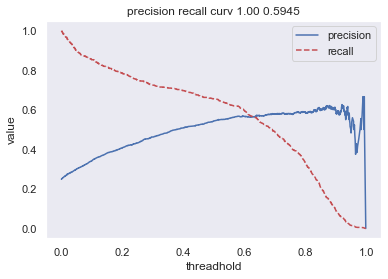

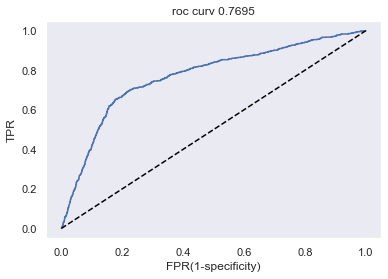

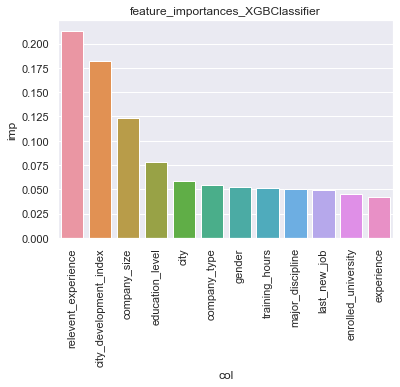

=========3차 평가 : NearMiss 언더샘플링 ======= ******************************
NearMiss 적용 전 : ((15326, 12), (15326,))
NearMiss 적용 후 : ((7644, 12), (7644,))
NearMiss 적용 후 : ((1910, 12), (1910,))
0    3822
1    3822
Name: target, dtype: int64
0    955
1    955
Name: target, dtype: int64
RandomForestClassifier
정확도0.6843 정밀도:0.6654 재현률:0.7414 f1:0.7013
오차행렬
 [[599 356]
 [247 708]]


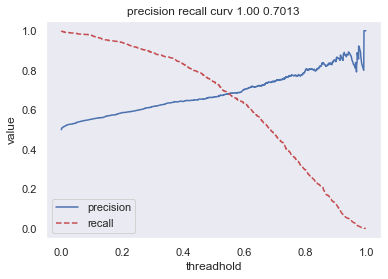

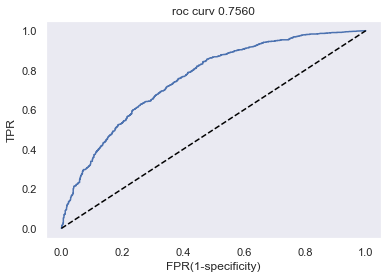

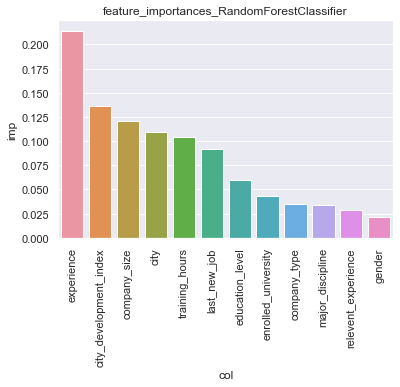

LGBMClassifier
정확도0.7173 정밀도:0.6769 재현률:0.8314 f1:0.7462
오차행렬
 [[576 379]
 [161 794]]


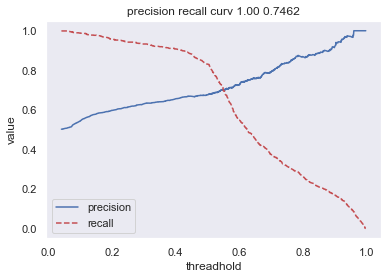

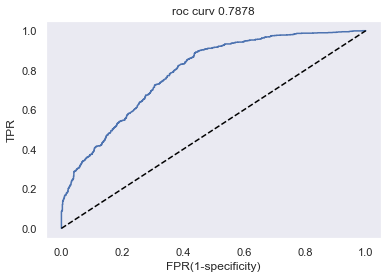

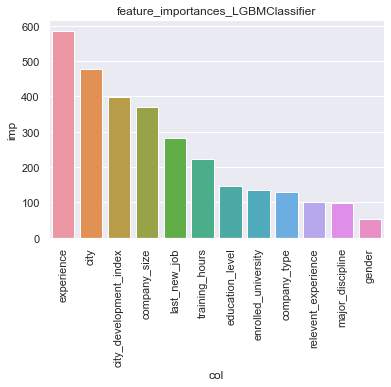

[03:33:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier
정확도0.7021 정밀도:0.6821 재현률:0.7571 f1:0.7176
오차행렬
 [[618 337]
 [232 723]]


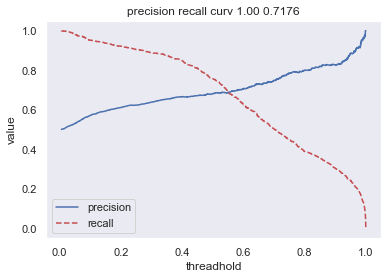

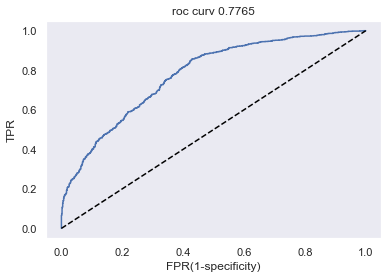

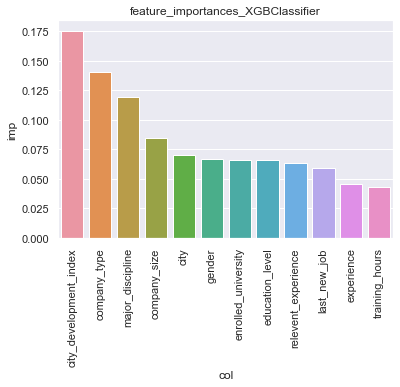

In [99]:
y = df['target']
X = df.drop('target', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=36, stratify=y)   #------Stratified 기반 분할

rf     = RandomForestClassifier(n_estimators=300,random_state=1414) 
lgbm   = LGBMClassifier(boost_from_average=False) #불균형일경우 필수 : boost_from_average=False
xgb    = XGBClassifier(objective='binary:logistic',n_estimators=300, seed=1414)

#------------------------------------
# 1차 평가 : 불균형 데이터
#------------------------------------
print("=========1차 평가 : 불균형 데이터 =======", "*" * 30)
models = [rf, lgbm, xgb]
for model in models :
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    proba = model.predict_proba(X_test)
    print(model.__class__.__name__)
    my_eval(y_test, pred, proba, th=1)
    
    imp_df = pd.DataFrame({'col': X.columns, 'imp': model.feature_importances_})
    imp_df = imp_df.sort_values(by='imp',ascending=False)
    # print(imp_df)

    g = sns.barplot(x='col',y='imp',data=imp_df)
    g.set_xticklabels(g.get_xticklabels(),rotation=90)
    g.set_title('feature_importances_ %s'% model.__class__.__name__)
    plt.show() 
    
    
# ========================== SMOTE 오버샘플링 =============================
print("=========2차 평가 : SMOTE 오버샘플링 =======", "*" * 30)
smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
print(f'SMOTE 적용 전 : {X_train.shape, y_train.shape}')
print(f'SMOTE 적용 후 : {X_train_over.shape, y_train_over.shape}')
print(f'{pd.Series(y_train_over).value_counts()}')


#------------------------------------
# 2차 평가 : 오버샘플링
# 일반적으로 오버샘플링시 : 재현율은 높아지고 정밀도는 낮아진다.
#------------------------------------
models =  [rf, lgbm,xgb]
for model in models :
    model.fit(X_train_over, y_train_over)  #SMOTE 증식된 X_train_over, y_train_over 주의!!!
    pred = model.predict(X_test)
    proba = model.predict_proba(X_test)
    print(model.__class__.__name__)
    my_eval(y_test, pred, proba, th=1)
    
    imp_df = pd.DataFrame({'col': X.columns, 'imp': model.feature_importances_})
    imp_df = imp_df.sort_values(by='imp',ascending=False)
    # print(imp_df)

    g = sns.barplot(x='col',y='imp',data=imp_df)
    g.set_xticklabels(g.get_xticklabels(),rotation=90)
    g.set_title('Oversample feature_importances_ %s'% model.__class__.__name__)
    plt.show() 
    

# ========================== NearMiss 언더샘플링 =============================
print("=========3차 평가 : NearMiss 언더샘플링 =======", "*" * 30)
nearmiss = NearMiss()
X_train_under, y_train_under = nearmiss.fit_resample(X_train, y_train)
X_test_under,  y_test_under  = nearmiss.fit_resample(X_test, y_test)
print(f'NearMiss 적용 전 : {X_train.shape, y_train.shape}')
print(f'NearMiss 적용 후 : {X_train_under.shape, y_train_under.shape}')
print(f'NearMiss 적용 후 : {X_test_under.shape, y_test_under.shape}')
print(f'{pd.Series(y_train_under).value_counts()}')
print(f'{pd.Series(y_test_under).value_counts()}')

#------------------------------------
# 3차 평가 : 언더샘플링
# 일반적으로 언더샘플링시 : 학습 데이터가 적어 오버피팅/언더피팅 발생
#------------------------------------
models =  [rf, lgbm, xgb]
for model in models :
    model.fit(X_train_under, y_train_under)  #NearMiss 감소된 X_train_under, y_train_under 주의!!!
    pred = model.predict(X_test_under)
    proba = model.predict_proba(X_test_under)
#     print("--3차평가--", y_test_under.shape, pred.shape)
    print(model.__class__.__name__)
    my_eval(y_test_under, pred, proba, th=1)
    
    
    imp_df = pd.DataFrame({'col': X.columns, 'imp': model.feature_importances_})
    imp_df = imp_df.sort_values(by='imp',ascending=False)
    # print(imp_df)

    g = sns.barplot(x='col',y='imp',data=imp_df)
    g.set_xticklabels(g.get_xticklabels(),rotation=90)
    g.set_title('Undersample feature_importances_%s'% model.__class__.__name__)
    plt.show() 
##  일반적으로 SMOTE 를 적용하면 재현율은 높아지지만 정밀도는 떨어진다


In [ ]:
# cboost = CatBoostClassifier(iterations=300, eval_metric='F1',use_best_model=True,random_seed=1414)
# # X_train_under, y_train_under
# # cate_features_index = np.where(x.dtypes != float)[0]
# cate_features_index = df.columns
# cboost.fit(X_train_under, y_train_under,cat_features=cate_features_index,eval_set=(X_test_under, y_test_under))
# cv_data = cv(model.get_params(),Pool(X_train_under, y_train_under,cat_features=cate_features_index),fold_count=10)
# print('the best cv accuracy is :{}'.format(np.max(cv_data["b'F1'_test_avg"])))
# print('the test accuracy is :{:.6f}'.format(f1_score(y_test_under,model.predict(X_test_under))))

#-----------------------------

# cboost = CatBoostClassifier( depth=3,iterations=300, eval_metric='f1',random_seed=1414, logging_level='Silent')
# cv_data = cv(
#     train_pool,
#     model.get_params(),
#     fold_count=5
# )
# print('Best validation accuracy score: {:.2f}±{:.2f} on step {}'.format(
#     np.max(cv_data['test-Accuracy-mean']), 
#     cv_data['test-Accuracy-std'][cv_data['test-Accuracy-mean'].idxmax(axis=0)],
#     cv_data['test-Accuracy-mean'].idxmax(axis=0)
# ))
# print('Precise validation accuracy score: {}'.format(np.max(cv_data['test-Accuracy-mean'])))
# model.fit(train_pool);
# model.score(X_train, Y_train)